In [1]:
import pandas as pd
import networkx as nx
from google.colab import drive
drive.mount('/content/drive')

def read_graph(csv_path):
    print("📥 Reading graph CSV...")
    df = pd.read_csv(csv_path)
    df.rename(columns={
        'Source Node  ID': 'source',
        'Target Node ID': 'target',
        'Edge Weight': 'weight'
    }, inplace=True)
    df['source'] = df['source'].astype(str)
    df['target'] = df['target'].astype(str)
    edges = list(df.itertuples(index=False, name=None))
    node_set = sorted(set(u for u, v, _ in edges).union(v for u, v, _ in edges))
    node_to_index = {node: i for i, node in enumerate(node_set)}
    index_to_node = {i: node for node, i in node_to_index.items()}
    edges_indexed = [(node_to_index[u], node_to_index[v], float(w)) for (u, v, w) in edges]
    print(f"✅ Graph loaded: {len(edges_indexed)} edges, {len(node_to_index)} nodes")
    return edges_indexed, node_to_index, index_to_node


def load_initial_scores(csv_path, node_to_index):
    print("📥 Reading ranking CSV...")
    df = pd.read_csv(csv_path)
    df['Node ID'] = df['Node ID'].astype(str).str.strip()
    rank_map = {row['Node ID']: row['Order'] for _, row in df.iterrows()}

    scores = {}
    for node_str, idx in node_to_index.items():
        if node_str in rank_map and idx not in scores:
            scores[idx] = int(rank_map[node_str])

    max_rank = max(scores.values(), default=0) + 1
    for node_str, idx in node_to_index.items():
        if idx not in scores:
            scores[idx] = max_rank
            max_rank += 1

    print(f"✅ Ranking loaded: {len(scores)} scores assigned")
    return scores


def check_scc_topological_violations(edge_csv, ranking_csv):
    print("🚀 Starting SCC violation check...")
    edges, node_to_index, index_to_node = read_graph(edge_csv)
    scores = load_initial_scores(ranking_csv, node_to_index)

    print("🔧 Building directed graph...")
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    print(f"✅ Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    print("🔍 Computing strongly connected components...")
    sccs = list(nx.strongly_connected_components(G))
    node_to_scc = {}
    for scc_index, scc in enumerate(sccs):
        for node in scc:
            node_to_scc[node] = scc_index
    print(f"✅ Found {len(sccs)} strongly connected components")

    print("🛠️ Building SCC DAG...")
    scc_dag = nx.DiGraph()
    for u, v, _ in edges:
        if u in node_to_scc and v in node_to_scc:
            scc_u = node_to_scc[u]
            scc_v = node_to_scc[v]
            if scc_u != scc_v:
                scc_dag.add_edge(scc_u, scc_v)
    print(f"✅ DAG has {scc_dag.number_of_nodes()} nodes and {scc_dag.number_of_edges()} edges")

    print("📏 Performing topological sort on SCC DAG...")
    scc_order = list(nx.topological_sort(scc_dag))
    scc_rank = {scc: i for i, scc in enumerate(scc_order)}
    print(f"✅ Topological sort completed")

    print("📊 Checking ranking violations between consecutive nodes (considering reachability)...")
    sorted_nodes = sorted(scores.items(), key=lambda x: x[1])
    violations = []

    for i in range(len(sorted_nodes) - 1):
        u, score_u = sorted_nodes[i]
        v, score_v = sorted_nodes[i + 1]

        if u not in node_to_scc or v not in node_to_scc:
            continue

        scc_u = node_to_scc[u]
        scc_v = node_to_scc[v]

        if scc_u == scc_v:
            continue

        try:
            if nx.has_path(scc_dag, scc_u, scc_v):
                if scc_rank[scc_u] > scc_rank[scc_v]:
                    violations.append((u, v, scc_u, scc_v, score_u, score_v))
        except nx.NodeNotFound:
            continue

    print(f"❗ Found {len(violations)} violations of topological SCC order in the input ranking.")
    for u, v, su, sv, ru, rv in violations[:20]:
        print(f"Violation: Node {u} (SCC {su}, rank {ru}) is ranked after Node {v} (SCC {sv}, rank {rv})")

    return violations


Mounted at /content/drive


In [ ]:
violations = check_scc_topological_violations(
    edge_csv="/content/drive/MyDrive/connectome_graph.csv",
    ranking_csv="/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv"
)


🚀 Starting SCC violation check...
📥 Reading graph CSV...
✅ Graph loaded: 5657719 edges, 136648 nodes
📥 Reading ranking CSV...
✅ Ranking loaded: 136648 scores assigned
🔧 Building directed graph...
✅ Graph constructed with 136648 nodes and 5657719 edges
🔍 Computing strongly connected components...
✅ Found 9626 strongly connected components
🛠️ Building SCC DAG...
✅ DAG has 9624 nodes and 11680 edges
📏 Performing topological sort on SCC DAG...
✅ Topological sort completed
📊 Checking ranking violations between consecutive nodes (considering reachability)...
❗ Found 0 violations of topological SCC order in the input ranking.


In [2]:
import pandas as pd
import itertools

def partition_recursive(scores, level, x=3, start=None, end=None):
    # Default range
    if start is None:
        start = min(scores.values())
    if end is None:
        end = max(scores.values())

    # Get sorted list of node IDs in range (lowest RAM way)
    sorted_nodes = sorted((node for node, score in scores.items() if start <= score <= end),
                          key=lambda node: scores[node])

    # Use index ranges instead of copying node sublists repeatedly
    index_ranges = [(0, len(sorted_nodes))]

    for _ in range(level):
        new_ranges = []
        for start_idx, end_idx in index_ranges:
            size = end_idx - start_idx
            base = size // x
            remainder = size % x
            offsets = [base + (1 if i == x - 1 else 0) for i in range(x)]

            sub_start = start_idx
            for s in offsets:
                new_ranges.append((sub_start, sub_start + s))
                sub_start += s
        index_ranges = new_ranges

    # Yield final partitions as sets
    return [set(sorted_nodes[start:end]) for start, end in index_ranges]

def partition_flat(scores, level, x=3, start=None, end=None):
    # Same input and output format as partition_recursive

    # Determine score bounds
    if start is None:
        start = min(scores.values())
    if end is None:
        end = max(scores.values())

    # Collect and sort nodes within the score range
    sorted_nodes = sorted(
        (node for node, score in scores.items() if start <= score <= end),
        key=lambda node: scores[node]
    )

    # Compute total partitions
    num_parts = x ** level
    total = len(sorted_nodes)
    base_size = total // num_parts
    remainder = total % num_parts

    # Divide into parts with balanced sizes
    parts = []
    idx = 0
    for i in range(num_parts):
        size = base_size + (1 if i < remainder else 0)
        parts.append(set(sorted_nodes[idx:idx + size]))
        idx += size

    return parts


def evaluate_within_parent_groups(scores, parts, edges_indexed, x):
    num_parts = len(parts)
    part_map = {}
    for i, part in enumerate(parts):
        for node in part:
            part_map[node] = i

    # Compute inter-part weights
    part_weights = [[0] * num_parts for _ in range(num_parts)]
    for u, v, w in edges_indexed:
        i, j = part_map[u], part_map[v]
        part_weights[i][j] += w

    inconsistencies = []
    group_count = num_parts // x

    for g in range(group_count):
        group = list(range(g * x, (g + 1) * x))
        part_ranks = [min(scores[node] for node in parts[i]) for i in group]
        initial_order = sorted(group, key=lambda i: part_ranks[group.index(i)])

        def forward_weight(order):
            weight = 0
            for i in range(x):
                for j in range(i + 1, x):
                    weight += part_weights[order[i]][order[j]]
            return weight

        perms = list(itertools.permutations(group))
        weights = [(perm, forward_weight(perm)) for perm in perms]
        best_perm, best_weight = max(weights, key=lambda x: x[1])
        initial_weight = forward_weight(initial_order)

        if tuple(initial_order) != best_perm:
            inconsistencies.append({
                "group": group,
                "initial_order": tuple(initial_order),
                "best_order": best_perm,
                "initial_weight": initial_weight,
                "best_weight": best_weight
            })

    return inconsistencies

def find_first_inconsistent_level(scores, edges_indexed, max_level=5, x=3):
    for level in range(1, max_level + 1):
        num_blocks = x ** level
        print(f"🔍 Checking level {level} with {num_blocks} blocks (branching factor = {x})...")
        parts = partition_recursive(scores, level, x)
        inconsistencies = evaluate_within_parent_groups(scores, parts, edges_indexed, x)

        if inconsistencies:
            print(f"❌ Inconsistency found at level {level} in {len(inconsistencies)} group(s)")
            for inc in inconsistencies:
                print(f"  Group {inc['group']}:")
                print(f"    Initial order = {inc['initial_order']}, weight = {inc['initial_weight']}")
                print(f"    Best order    = {inc['best_order']}, weight = {inc['best_weight']}")
            return level
        else:
            print(f"✅ Level {level} is consistent")
    print("✅ No inconsistencies found up to max level")
    return None




In [ ]:
def compute_total_forward_weight(edges, scores):
    return sum(w for u, v, w in edges if scores[u] < scores[v])

# === Step 5: Evaluate and Reorder ===
import itertools


def evaluate_and_reorder(scores, parts, edges_indexed, x, start=None, end=None):
    num_parts = len(parts)
    part_map = {}
    for i, part in enumerate(parts):
        for node in part:
            part_map[node] = i

    # Compute part-to-part weights (no change)
    part_weights = [[0] * num_parts for _ in range(num_parts)]
    for u, v, w in edges_indexed:
        if u in part_map and v in part_map:
            i, j = part_map[u], part_map[v]
            part_weights[i][j] += w

    changed = False
    group_count = num_parts // x

    for g in range(group_count):
        group = list(range(g * x, (g + 1) * x))

        def min_rank(i):
            return min(scores[n] for n in parts[i])

        initial_order = sorted(group, key=min_rank)

        def forward_weight(order):
            return sum(
                part_weights[order[i]][order[j]]
                for i in range(x) for j in range(i + 1, x)
            )

        # Memory-efficient permutation search
        best_perm = None
        best_weight = -1
        for perm in itertools.permutations(group):
            w = forward_weight(perm)
            if w > best_weight:
                best_weight = w
                best_perm = perm

        initial_weight = forward_weight(initial_order)

        if tuple(initial_order) != best_perm:
            changed = True
            print(f"  Reordering group {group}:")
            print(f"    Initial order = {tuple(initial_order)}, weight = {initial_weight}")
            print(f"    Best order    = {best_perm}, weight = {best_weight}")

            # Work directly with node generators to reduce memory
            combined = (node for i in group for node in parts[i])
            sorted_combined = sorted(combined, key=lambda n: scores[n])

            new_order = []
            for i in best_perm:
                block_sorted = sorted(parts[i], key=lambda n: scores[n])
                new_order.extend(block_sorted)

            base_score = scores[sorted_combined[0]]
            for new_rank, node in enumerate(new_order):
                if start is None or end is None or start <= scores[node] <= end:
                    scores[node] = base_score + new_rank

    return changed




# === Step 6: Export Final Rankings ===
def finalize_and_export(scores, index_to_node, output_excel):
    n = len(scores)
    ranked = [(str(index_to_node[v]), scores[v]) for v in range(n)]
    ranked.sort(key=lambda x: x[1])
    df = pd.DataFrame(ranked, columns=["Node ID", "Order"])
    df.to_csv(output_excel, index=False)
    print(f"✅ Final ranking saved to {output_excel}")

# === Step 7: Run Full Process ===
graph_file = "/content/drive/MyDrive/connectome_graph.csv"
ranking_file = "/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv"
output_excel = "/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv"

import math

edges_indexed, node_to_index, index_to_node = read_graph(graph_file)
scores = load_initial_scores(ranking_file, node_to_index)

print("📊 Initial forward weight:")
before_weight = compute_total_forward_weight(edges_indexed, scores)
print(before_weight)

x = 6
start = 0
end = len(scores)-1

max_level = min(int(math.log(end - start + 1, x)), int(math.log(900000, x)))

print(f"🔁 Evaluating level = {max_level} for partial ranking: scores[{start}:{end}]")

parts = partition_flat(scores, level=max_level, x=x, start=start, end=end)
_ = evaluate_and_reorder(scores, parts, edges_indexed, x=x, start=start, end=end)


print("📈 Forward weight after reordering:")
after_weight = compute_total_forward_weight(edges_indexed, scores)
print(after_weight)

finalize_and_export(scores, index_to_node, output_excel)

📥 Reading graph CSV...


KeyboardInterrupt: 

In [3]:


import os
import pandas as pd
import networkx as nx
from itertools import permutations

def compute_scc_optimized_ranking_and_forward_weight(edge_csv, ranking_csv, output_csv):
    print("🚀 Starting SCC-based forward weight optimization...")

    # Step 1: Read graph and initial scores
    edges, node_to_index, index_to_node = read_graph(edge_csv)
    scores = load_initial_scores(ranking_csv, node_to_index)

    print("🔧 Building directed graph...")
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    print(f"✅ Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    print("🔍 Finding strongly connected components...")
    sccs = list(nx.strongly_connected_components(G))
    node_to_scc = {}
    for i, scc in enumerate(sccs):
        for node in scc:
            node_to_scc[node] = i
    print(f"✅ Found {len(sccs)} strongly connected components")

    print("🛠️ Building SCC DAG...")
    scc_dag = nx.DiGraph()
    scc_dag.add_nodes_from(range(len(sccs)))  # Add all SCCs even if isolated
    for u, v, _ in edges:
        su, sv = node_to_scc[u], node_to_scc[v]
        if su != sv:
            scc_dag.add_edge(su, sv)
    print(f"✅ DAG: {scc_dag.number_of_nodes()} nodes, {scc_dag.number_of_edges()} edges")

    print("📏 Topologically sorting SCCs...")
    try:
        scc_order = list(nx.topological_sort(scc_dag))
    except nx.NetworkXUnfeasible:
        print("❌ Error: SCC DAG is not a DAG (cycle detected)!")
        return None
    print(f"✅ SCC topological sort complete. Order length = {len(scc_order)}")

    print("⚙️ Ranking nodes SCC by SCC...")
    node_order = {}
    current_rank = 0
    visited_scc_ids = set()

    for scc_id in scc_order:
        visited_scc_ids.add(scc_id)
        component = list(sccs[scc_id])
        print(f"🔹 SCC {scc_id} with {len(component)} nodes")

        if len(component) <= 9:
            print("   🔄 Permuting to maximize internal forward weight...")
            initial_sorted = sorted(component, key=lambda n: scores.get(n, float('inf')))
            best_order = []
            max_internal_fw = -1
            for perm in permutations(initial_sorted):
                pos = {node: i for i, node in enumerate(perm)}
                fw = sum(
                    G[u][v]['weight']
                    for u in perm for v in perm
                    if G.has_edge(u, v) and pos[u] < pos[v]
                )
                if fw > max_internal_fw:
                    max_internal_fw = fw
                    best_order = perm
            sorted_nodes = best_order
            print(f"   ✅ Best internal forward weight: {max_internal_fw:.2f}")
        else:
            print("   ➡️ Too large for permutation, using initial rank sort")
            sorted_nodes = sorted(component, key=lambda n: scores.get(n, float('inf')))

        for node in sorted_nodes:
            node_order[node] = current_rank
            current_rank += 1

    # Check for unvisited SCCs (possibly isolated or not reachable in DAG)
    all_scc_ids = set(range(len(sccs)))
    unvisited_scc_ids = all_scc_ids - visited_scc_ids
    if unvisited_scc_ids:
        print(f"❗ {len(unvisited_scc_ids)} SCCs were not visited during topological sort.")
        for scc_id in sorted(unvisited_scc_ids)[:5]:
            print(f"  🚫 Skipped SCC {scc_id} with {len(sccs[scc_id])} nodes. Example nodes: {list(sccs[scc_id])[:3]}")

    print("📊 Computing total forward edge weight of new ranking...")
    new_fw = sum(
        w for u, v, w in edges if node_order.get(u, -1) < node_order.get(v, -1)
    )
    print(f"🎯 Total forward edge weight of new ranking: {new_fw:.2f}")

    should_write = True
    if os.path.exists(output_csv):
        print("📁 Comparing with existing ranking...")
        existing_scores = load_initial_scores(output_csv, node_to_index)
        existing_fw = sum(
            w for u, v, w in edges
            if existing_scores.get(u, float('inf')) < existing_scores.get(v, float('inf'))
        )
        print(f"📁 Existing ranking has forward weight: {existing_fw:.2f}")
        if new_fw <= existing_fw:
            print("⛔ New ranking is not strictly better. Skipping write.")
            should_write = False

    if should_write:
        print("💾 Writing new ranking to output CSV...")
        ranked = [(index_to_node[n], r) for n, r in sorted(node_order.items(), key=lambda x: x[1])]
        pd.DataFrame(ranked, columns=["Node ID", "Order"]).to_csv(output_csv, index=False)
        print(f"✅ Ranking written to {output_csv}")

    return new_fw





In [4]:
compute_scc_optimized_ranking_and_forward_weight(
    edge_csv="/content/drive/MyDrive/connectome_graph.csv",
    ranking_csv="/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv",
    output_csv="/content/drive/MyDrive/35461047-Soroush-Ioannis-sccsorted.csv"
)




Streaming output truncated to the last 5000 lines.
   ✅ Best internal forward weight: 0.00
🔹 SCC 1355 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 1666 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 1429 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 1662 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 114 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 112 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 94 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best internal forward weight: 0.00
🔹 SCC 286 with 1 nodes
   🔄 Permuting to maximize internal forward weight...
   ✅ Best 

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import networkx as nx
from collections import Counter



def count_sccs_by_size_fast():
    print("📥 Reading graph from /content/drive/MyDrive/connectome_graph.csv...")
    df = pd.read_csv("/content/drive/MyDrive/connectome_graph.csv")
    df.rename(columns={
        'Source Node  ID': 'source',
        'Target Node ID': 'target',
        'Edge Weight': 'weight'
    }, inplace=True)
    df['source'] = df['source'].astype(str)
    df['target'] = df['target'].astype(str)

    print("🔧 Building graph (fast)...")
    G = nx.DiGraph()
    G.add_weighted_edges_from(zip(df['source'], df['target'], df['weight']))

    print("🔍 Finding strongly connected components...")
    sccs = nx.strongly_connected_components(G)  # generator, memory-efficient
    size_counts = Counter(len(scc) for scc in sccs)

    print("📊 SCC size distribution:")
    for size in sorted(size_counts):
        print(f"Size {size}: {size_counts[size]} component(s)")

    return size_counts

u=count_sccs_by_size_fast()

📥 Reading graph from /content/drive/MyDrive/connectome_graph.csv...
🔧 Building graph (fast)...
🔍 Finding strongly connected components...
📊 SCC size distribution:
Size 1: 9503 component(s)
Size 2: 92 component(s)
Size 3: 17 component(s)
Size 4: 5 component(s)
Size 5: 2 component(s)
Size 6: 3 component(s)
Size 7: 2 component(s)
Size 8: 1 component(s)
Size 126840: 1 component(s)


In [7]:


import pandas as pd
import networkx as nx
from itertools import permutations
from collections import Counter

def refine_largest_scc_toposorted_blocks(sz=7000):
    import pandas as pd
    import networkx as nx
    from itertools import permutations
    from collections import Counter

    def read_graph(csv_path):
        print("📥 Reading graph CSV...")
        df = pd.read_csv(csv_path)
        df.rename(columns={
            'Source Node  ID': 'source',
            'Target Node ID': 'target',
            'Edge Weight': 'weight'
        }, inplace=True)
        df['source'] = df['source'].astype(str)
        df['target'] = df['target'].astype(str)
        edges = list(df.itertuples(index=False, name=None))
        print(f"✅ Loaded graph with {len(edges)} edges")
        return edges

    def load_initial_ranking(csv_path):
        print("📥 Reading ranking CSV...")
        df = pd.read_csv(csv_path)
        df['Node ID'] = df['Node ID'].astype(str).str.strip()
        ranking = dict(zip(df['Node ID'], df['Order']))
        print(f"✅ Loaded ranking for {len(ranking)} nodes")
        return ranking

    edge_path = "/content/drive/MyDrive/connectome_graph.csv"
    output_path = "/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv"

    edges = read_graph(edge_path)
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)

    initial_order = load_initial_ranking(output_path)
    node_order = initial_order.copy()

    sccs = list(nx.strongly_connected_components(G))
    largest_scc = max(sccs, key=len)
    largest_scc_nodes = sorted(
        [node for node in node_order if node in largest_scc],
        key=lambda n: node_order[n]
    )

    total_steps = len(largest_scc_nodes) // sz
    bias = sz-2

    for step in range(total_steps):

        block_nodes = largest_scc_nodes[bias + step * sz : bias + (step + 1) * sz]
        print(f"\n=== Step {step + 1}/{total_steps} ===")
        print(f"Block size: {len(block_nodes)}")

        # Construct subgraph with all block_nodes explicitly included
        subG = G.subgraph(block_nodes).copy()


        # Debug graph completeness
        print(f"Subgraph nodes: {len(subG.nodes)}, Expected block nodes: {len(block_nodes)}")

        # Check if subG is missing nodes
        missing_in_subG = set(block_nodes) - set(subG.nodes)
        if missing_in_subG:
            print(f"⚠️ {len(missing_in_subG)} nodes missing from subG. Example: {list(missing_in_subG)[:5]}")

        # Decompose block into SCCs
        sub_sccs = list(nx.strongly_connected_components(subG))
        print(f"  Found {len(sub_sccs)} SCCs in block")

        # Track SCC node coverage
        covered_nodes = set()
        node_to_subscc = {}
        for idx, scc in enumerate(sub_sccs):
            covered_nodes.update(scc)
            for node in scc:
                node_to_subscc[node] = idx

        uncovered = set(block_nodes) - covered_nodes
        if uncovered:
            print(f"❌ {len(uncovered)} block nodes not covered by SCCs. Example: {list(uncovered)[:5]}")

        # Build SCC DAG
        # Build SCC DAG and topologically sort the sub-SCCs
        scc_dag = nx.DiGraph()
        scc_dag.add_nodes_from(range(len(sub_sccs)))  # Ensure all SCCs are present, even isolated ones
        for u, v in subG.edges():
            su, sv = node_to_subscc[u], node_to_subscc[v]
            if su != sv:
                scc_dag.add_edge(su, sv)

        scc_order = list(nx.topological_sort(scc_dag))


        # Build new order
        new_block_order = []
        print(f"Total SCCs found: {len(sub_sccs)}")
        print(f"Topologically sorted SCCs: {len(scc_order)}")

        visited_scc_ids = set()
        new_block_order = []

        for scc_id in scc_order:
            visited_scc_ids.add(scc_id)
            scc_nodes = list(sub_sccs[scc_id])
         #   print(f"  ➕ SCC {scc_id} has {len(scc_nodes)} nodes")

            if len(scc_nodes) <= 9:
                best_perm = []
                max_weight = -1
                for perm in permutations(scc_nodes):
                    weight = sum(
                        subG[u][v]['weight']
                        for i, u in enumerate(perm)
                        for j, v in enumerate(perm)
                        if i < j and subG.has_edge(u, v)
                    )
                    if weight > max_weight:
                        max_weight = weight
                        best_perm = perm
                new_block_order.extend(best_perm)
            else:
                sorted_original = sorted(scc_nodes, key=lambda n: node_order[n])
                new_block_order.extend(sorted_original)

        # Detect unvisited SCCs (likely due to being isolated)
        all_scc_ids = set(range(len(sub_sccs)))
        unvisited_scc_ids = all_scc_ids - visited_scc_ids
        if unvisited_scc_ids:
            print(f"❗ {len(unvisited_scc_ids)} SCCs were not visited during topological sort.")
            for scc_id in sorted(unvisited_scc_ids)[:5]:
                print(f"  🚫 Skipped SCC {scc_id} with {len(sub_sccs[scc_id])} nodes. Example nodes: {list(sub_sccs[scc_id])[:3]}")

        # Final check
        print(f"New block order length: {len(new_block_order)}")
        missing = set(block_nodes) - set(new_block_order)
        if missing:
            print(f"❌ Final mismatch in new_block_order: {len(missing)} nodes missing.")
            print(f"  Missing (up to 5): {list(missing)[:5]}")
            raise ValueError("Block nodes missing from new_block_order!")

        print(f"✅ All {len(block_nodes)} nodes successfully added to new_block_order.")


        base_rank = min(node_order[n] for n in block_nodes)
        for i, node in enumerate(new_block_order):
            node_order[node] = base_rank + i

        all_ranks = list(node_order.values())
        if len(all_ranks) != len(set(all_ranks)):
            duplicates = [rank for rank, count in Counter(all_ranks).items() if count > 1]
            print(f"❌ Duplicate ranks detected after step {step + 1} — {len(duplicates)} non-unique ranks found.")
            for rank in duplicates[:10]:
                nodes = [n for n, r in node_order.items() if r == rank]
                print(f"  Rank {rank} is assigned to {len(nodes)} nodes: {nodes}")
            raise ValueError("Duplicate ranks detected in node_order!")

        df_existing = pd.read_csv(output_path)
        df_existing['Node ID'] = df_existing['Node ID'].astype(str).str.strip()
        existing_order = dict(zip(df_existing['Node ID'], df_existing['Order']))
        existing_fw = sum(
            w for u, v, w in edges
            if existing_order.get(u, float('inf')) < existing_order.get(v, float('inf'))
        )

        new_fw = sum(
            w for u, v, w in edges
            if node_order.get(u, float('inf')) < node_order.get(v, float('inf'))
        )

        print(f"Step {step + 1}: New FW = {new_fw:.2f}, Existing FW = {existing_fw:.2f}")

        if new_fw > existing_fw:
            print("✅ Improvement detected. Saving new ranking.")
            ranked = [(node, order) for node, order in sorted(node_order.items(), key=lambda x: x[1])]
            pd.DataFrame(ranked, columns=["Node ID", "Order"]).to_csv(output_path, index=False)
        else:
            if existing_fw > new_fw:
                print("↩️  Reverting to better saved ranking.")
                node_order = existing_order.copy()
            else:
                print("⏭️  No strict improvement in either direction. Keeping current ranking in memory.")







In [8]:
refine_largest_scc_toposorted_blocks()


📥 Reading graph CSV...
✅ Loaded graph with 5657719 edges
📥 Reading ranking CSV...
✅ Loaded ranking for 136648 nodes

=== Step 1/18 ===
Block size: 7000
Subgraph nodes: 7000, Expected block nodes: 7000
  Found 1609 SCCs in block
Total SCCs found: 1609
Topologically sorted SCCs: 1609
New block order length: 7000
✅ All 7000 nodes successfully added to new_block_order.
Step 1: New FW = 35462925.00, Existing FW = 35462925.00
⏭️  No strict improvement in either direction. Keeping current ranking in memory.

=== Step 2/18 ===
Block size: 7000
Subgraph nodes: 7000, Expected block nodes: 7000
  Found 323 SCCs in block
Total SCCs found: 323
Topologically sorted SCCs: 323
New block order length: 7000
✅ All 7000 nodes successfully added to new_block_order.
Step 2: New FW = 35462925.00, Existing FW = 35462925.00
⏭️  No strict improvement in either direction. Keeping current ranking in memory.

=== Step 3/18 ===
Block size: 7000
Subgraph nodes: 7000, Expected block nodes: 7000
  Found 664 SCCs in bl


--- DB's Ranking ---
🔍 Number of back edges: 1157173
📏 Back edge length stats: min=1, max=136410, avg=20449.85, std=24081.19
⚖️  Back edge weight stats: sum=6452875.00, avg=5.58, std=8.91

--- Our Ranking ---
🔍 Number of back edges: 1156906
📏 Back edge length stats: min=1, max=126650, avg=20553.63, std=24556.83
⚖️  Back edge weight stats: sum=6449479.00, avg=5.57, std=8.90

📏 Forward edge weight comparison:
     DB's forward weight:   35459266.00 / 41912141.00 = 0.8460
     Ours forward weight:   35462662.00 / 41912141.00 = 0.8461


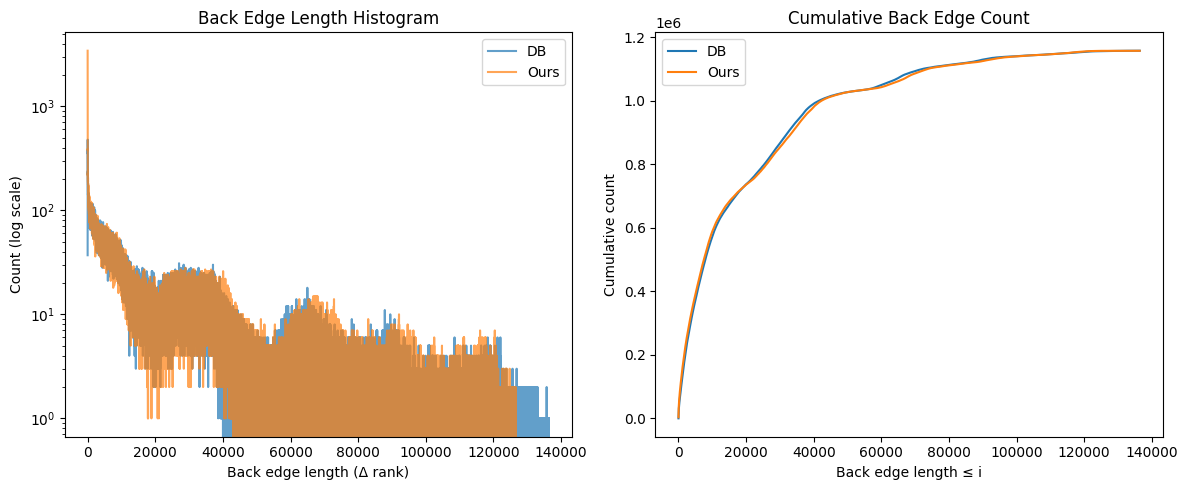

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def read_graph(path):
    df = pd.read_csv(path)
    df.rename(columns={
        'Source Node  ID': 'source',
        'Target Node ID': 'target',
        'Edge Weight': 'weight'
    }, inplace=True)
    df['source'] = df['source'].astype(str).str.strip()
    df['target'] = df['target'].astype(str).str.strip()
    nodes = sorted(set(df['source']).union(df['target']))
    node_to_index = {node: i for i, node in enumerate(nodes)}
    index_to_node = {i: node for node, i in node_to_index.items()}
    edges_indexed = [
        (node_to_index[src], node_to_index[tgt], float(w))
        for src, tgt, w in df[['source', 'target', 'weight']].values
    ]
    return edges_indexed, node_to_index, index_to_node

def load_initial_scores(path, node_to_index):
    df = pd.read_csv(path)
    df['Node ID'] = df['Node ID'].astype(str).str.strip()
    return {
        node_to_index[row['Node ID']]: int(row['Order'])
        for _, row in df.iterrows()
        if row['Node ID'] in node_to_index
    }

def analyze_back_edges(edges_indexed, scores, index_to_node, label="Ranking"):
    length_counts = defaultdict(int)
    back_lengths = []
    back_weights = []

    for u, v, w in edges_indexed:
        ru, rv = scores[u], scores[v]
        if ru > rv:
            length = ru - rv
            length_counts[length] += 1
            back_lengths.append(length)
            back_weights.append(w)

    count = len(back_lengths)
    avg_length = np.mean(back_lengths) if back_lengths else 0
    std_length = np.std(back_lengths) if back_lengths else 0
    min_length = min(back_lengths) if back_lengths else 0
    max_length = max(back_lengths) if back_lengths else 0

    total_back_weight = sum(back_weights)
    avg_back_weight = np.mean(back_weights) if back_weights else 0
    std_back_weight = np.std(back_weights) if back_weights else 0

    print(f"\n--- {label} ---")
    print(f"🔍 Number of back edges: {count}")
    print(f"📏 Back edge length stats: min={min_length}, max={max_length}, avg={avg_length:.2f}, std={std_length:.2f}")
    print(f"⚖️  Back edge weight stats: sum={total_back_weight:.2f}, avg={avg_back_weight:.2f}, std={std_back_weight:.2f}")

    cumulative = {}
    total = 0
    for i in range(1, max_length + 1):
        total += length_counts[i]
        cumulative[i] = total

    return count, length_counts, cumulative


def compute_forward_weight(edges_indexed, scores):
    fw = sum(w for u, v, w in edges_indexed if scores[u] < scores[v])
    total = sum(w for _, _, w in edges_indexed)
    return fw, total

def plot_histogram_and_cumulative(counts_db, cum_db, counts_ours, cum_ours):
    max_len = max(
        max(counts_db.keys(), default=0),
        max(counts_ours.keys(), default=0),
        2000
    )
    x_vals = list(range(1, max_len + 1))
    hist_db = [counts_db.get(i, 0) for i in x_vals]
    hist_ours = [counts_ours.get(i, 0) for i in x_vals]

    last_cum_db = 0
    cum_vals_db = []
    for i in x_vals:
        last_cum_db = cum_db.get(i, last_cum_db)
        cum_vals_db.append(last_cum_db)

    last_cum_ours = 0
    cum_vals_ours = []
    for i in x_vals:
        last_cum_ours = cum_ours.get(i, last_cum_ours)
        cum_vals_ours.append(last_cum_ours)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_vals, hist_db, label="DB", alpha=0.7)
    plt.plot(x_vals, hist_ours, label="Ours", alpha=0.7)
    plt.yscale('log')
    plt.title("Back Edge Length Histogram")
    plt.xlabel("Back edge length (Δ rank)")
    plt.ylabel("Count (log scale)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_vals, cum_vals_db, label="DB")
    plt.plot(x_vals, cum_vals_ours, label="Ours")
    plt.title("Cumulative Back Edge Count")
    plt.xlabel("Back edge length ≤ i")
    plt.ylabel("Cumulative count")
    plt.legend()

    plt.tight_layout()
    plt.show()


# === File Paths ===
graph_path = "/content/drive/MyDrive/connectome_graph.csv"
ours_path = "/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv"
db_path = "/content/drive/MyDrive/DB_challenge.csv"

# === Execution ===
edges_indexed, node_to_index, index_to_node = read_graph(graph_path)
scores_ours = load_initial_scores(ours_path, node_to_index)
scores_db = load_initial_scores(db_path, node_to_index)

count_db, counts_db, cum_db = analyze_back_edges(edges_indexed, scores_db, index_to_node, label="DB's Ranking")
count_ours, counts_ours, cum_ours = analyze_back_edges(edges_indexed, scores_ours, index_to_node, label="Our Ranking")


fw_db, total_db = compute_forward_weight(edges_indexed, scores_db)
fw_ours, total_ours = compute_forward_weight(edges_indexed, scores_ours)

print("\n📏 Forward edge weight comparison:")
print(f"     DB's forward weight:   {fw_db:.2f} / {total_db:.2f} = {fw_db / total_db:.4f}")
print(f"     Ours forward weight:   {fw_ours:.2f} / {total_ours:.2f} = {fw_ours / total_ours:.4f}")

plot_histogram_and_cumulative(counts_db, cum_db, counts_ours, cum_ours)




In [ ]:
import os
import pandas as pd
import networkx as nx
from itertools import permutations

def read_graph(csv_path):
    print("📥 Reading graph CSV...")
    df = pd.read_csv(csv_path)
    df.rename(columns={
        'Source Node  ID': 'source',
        'Target Node ID': 'target',
        'Edge Weight': 'weight'
    }, inplace=True)
    df['source'] = df['source'].astype(str)
    df['target'] = df['target'].astype(str)
    edges = list(df.itertuples(index=False, name=None))
    node_set = sorted(set(u for u, v, _ in edges).union(v for u, v, _ in edges))
    node_to_index = {node: i for i, node in enumerate(node_set)}
    index_to_node = {i: node for node, i in node_to_index.items()}
    edges_indexed = [(node_to_index[u], node_to_index[v], float(w)) for (u, v, w) in edges]
    print(f"✅ Graph loaded: {len(edges_indexed)} edges, {len(node_to_index)} nodes")
    return edges_indexed, node_to_index, index_to_node

def load_initial_scores(csv_path, node_to_index):
    print("📥 Reading ranking CSV...")
    df = pd.read_csv(csv_path)
    df['Node ID'] = df['Node ID'].astype(str).str.strip()
    rank_map = {row['Node ID']: row['Order'] for _, row in df.iterrows()}
    scores = {}
    for node_str, idx in node_to_index.items():
        if node_str in rank_map and idx not in scores:
            scores[idx] = int(rank_map[node_str])
    max_rank = max(scores.values(), default=0) + 1
    for node_str, idx in node_to_index.items():
        if idx not in scores:
            scores[idx] = max_rank
            max_rank += 1
    print(f"✅ Ranking loaded: {len(scores)} scores assigned")
    return scores

def compute_scc_optimized_ranking_with_filtered_backedges(edge_csv, ranking_csv):
    print("🚀 Starting SCC-based forward weight optimization with filtered back edges...")

    # Step 1: Read graph and initial scores
    edges, node_to_index, index_to_node = read_graph(edge_csv)
    scores = load_initial_scores(ranking_csv, node_to_index)

    print("🔧 Building directed graph...")
    G_full = nx.DiGraph()
    G_full.add_weighted_edges_from(edges)
    print(f"✅ Graph constructed: {G_full.number_of_nodes()} nodes, {G_full.number_of_edges()} edges")

    # Step 2: Identify backward edges and remove the lowest 50% by weight
    back_edges = [(u, v, w) for u, v, w in edges if scores[u] > scores[v]]
    back_edges_sorted = sorted(back_edges, key=lambda x: x[2])  # sort by weight ascending
    cutoff = len(back_edges_sorted) // 2
    back_edges_to_delete = set(back_edges_sorted[:cutoff])
    print(f"🔻 Removing {len(back_edges_to_delete)} low-weight backward edges before SCC analysis")

    edges_filtered = [e for e in edges if e not in back_edges_to_delete]

    # Step 3: Build filtered graph for SCC decomposition
    G_filtered = nx.DiGraph()
    G_filtered.add_weighted_edges_from(edges_filtered)

    print("🔍 Finding strongly connected components...")
    sccs = list(nx.strongly_connected_components(G_filtered))
    node_to_scc = {}
    for i, scc in enumerate(sccs):
        for node in scc:
            node_to_scc[node] = i
    print(f"✅ Found {len(sccs)} strongly connected components")

    print("🛠️ Building SCC DAG...")
    scc_dag = nx.DiGraph()
    for u, v, _ in edges_filtered:
        su, sv = node_to_scc[u], node_to_scc[v]
        if su != sv:
            scc_dag.add_edge(su, sv)
    print(f"✅ DAG: {scc_dag.number_of_nodes()} nodes, {scc_dag.number_of_edges()} edges")

    print("📏 Topologically sorting SCCs...")
    scc_order = list(nx.topological_sort(scc_dag))
    print("✅ SCC topological sort complete")

    print("⚙️ Ranking nodes...")
    node_order = {}
    current_rank = 0
    for scc_id in scc_order:
        component = list(sccs[scc_id])
        if len(component) > 1:
            print(f"🔹 SCC {scc_id} with {len(component)} nodes")

        if 1 < len(component) <= 9:
          print("   🔄 Trying all permutations to maximize internal forward weight...")
          initial_sorted = sorted(component, key=lambda n: scores.get(n, float('inf')))
          best_order = []
          max_internal_fw = -1

          # Build subgraph only once
          G_sub = G_full.subgraph(component).copy()

          for perm in permutations(initial_sorted):
              pos = {node: i for i, node in enumerate(perm)}
              fw = sum(
                  G_sub[u][v]['weight']
                  for u in G_sub.nodes
                  for v in G_sub[u]
                  if pos[u] < pos[v]
              )
              if fw > max_internal_fw:
                  max_internal_fw = fw
                  best_order = perm

          sorted_nodes = best_order
          print(f"   ✅ Best internal forward weight (reconsidering all edges): {max_internal_fw:.2f}")

        else:
           # print("   ➡️ Sorting by initial rank (too large to permute)")
            sorted_nodes = sorted(component, key=lambda n: scores.get(n, float('inf')))

        for node in sorted_nodes:
            node_order[node] = current_rank
            current_rank += 1

    # Compute forward weight of the initial ranking
    initial_fw = sum(
        w for u, v, w in edges if scores[u] < scores[v]
    )
    print(f"📊 Initial forward edge weight: {initial_fw:.2f}")

    # Compute forward weight of the optimized ranking
    new_fw = sum(
        w for u, v, w in edges if node_order.get(u, -1) < node_order.get(v, -1)
    )
    print(f"🎯 Total forward edge weight after optimization: {new_fw:.2f}")

    return new_fw
compute_scc_optimized_ranking_with_filtered_backedges(
    edge_csv="/content/drive/MyDrive/connectome_graph.csv",
    ranking_csv="/content/drive/MyDrive/35461047-Soroush-Ioannis-advancedimprove.csv"
)


🚀 Starting SCC-based forward weight optimization with filtered back edges...
📥 Reading graph CSV...
✅ Graph loaded: 5657719 edges, 136648 nodes
📥 Reading ranking CSV...
✅ Ranking loaded: 136648 scores assigned
🔧 Building directed graph...
✅ Graph constructed: 136648 nodes, 5657719 edges
🔻 Removing 578558 low-weight backward edges before SCC analysis
🔍 Finding strongly connected components...
✅ Found 11515 strongly connected components
🛠️ Building SCC DAG...
✅ DAG: 11515 nodes, 14197 edges
📏 Topologically sorting SCCs...
✅ SCC topological sort complete
⚙️ Ranking nodes...
🔹 SCC 2952 with 2 nodes
   🔄 Trying all permutations to maximize internal forward weight...
   ✅ Best internal forward weight (reconsidering all edges): 9.00
🔹 SCC 3065 with 2 nodes
   🔄 Trying all permutations to maximize internal forward weight...
   ✅ Best internal forward weight (reconsidering all edges): 7.00
🔹 SCC 3448 with 2 nodes
   🔄 Trying all permutations to maximize internal forward weight...
   ✅ Best inte

35461283.0